In [14]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import scipy.stats as stats
from matplotlib import gridspec
import aplpy as apl #The Astronomy Plotting Library for python
import astropy
from astropy.stats import sigma_clip
from astropy.modeling import functional_models, models, fitting
import astropy.units as U
from astropy.coordinates import ICRS, Galactic, FK4, FK5, Angle, Latitude, Longitude
import astropy.constants as C
from astropy import wcs
import astropy.io.fits as fits
from astropy.io import ascii
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.stats import signal_to_noise_oir_ccd as SNRas
#import spectral_cube as SC
#from spectral_cube import SpectralCube as sc
from astropy.wcs import WCS
matplotlib.use('Agg')
import matplotlib.cm as cm
#import astrometry as ast
import pyfits
import requests
import json
import os
from sklearn import datasets, linear_model
from scipy.optimize import curve_fit
import numpy.ma as ma
from astropy.table import Table, Column
import pyextract
import sewpy
import pandas as pd
#import alipy

In [15]:
quasJ = os.listdir('/../home/lynge/MasterP/NGC3783/NGC3783z/')
quasJ = [os.path.join('/../home/lynge/MasterP/NGC3783/NGC3783z',f) \
        for f in os.listdir('/../home/lynge/MasterP/NGC3783/NGC3783z/')]

qua1_RA_WORLD = 174.75717083
qua1_DEC_WORLD = -37.73850000
sta1_RA_WORLD = 174.77413750 - 9*10**(-5) #HD 101274
sta1_DEC_WORLD = -37.75375000 + 6.4*10**(-5)
sta2_RA_WORLD = 174.82283333 - 0.15/3600. #Tycho-2 7740-22-1
sta2_DEC_WORLD = -37.76239167
sta3_RA_WORLD = 174.79553333 #174.79553250 #Tycho-2 7740-529-1
sta3_DEC_WORLD = -37.83470278 #-37.83470333
gal_RA_WORLD = 174.69151250 + 0.6/3600.# Galaxy
gal_DEC_WORLD = -37.71181944 + 0.4/3600

sky_RA_WORLD = 174.75445032458904 #Random patch of sky
sky_DEC_WORLD = -37.77465736280882

MAG_HD101274_B = 9.23
MAG_HD101274_V = 9.12
MAG_HD101274_G = 9.192
MAG_HD101274_J = 8.997
MAG_HD101274_H = 8.982
MAG_HD101274_K = 8.909

MAG_TYCHO_2_7740_22_1_B = 12.58
MAG_TYCHO_2_7740_22_1_V = 12.12
MAG_TYCHO_2_7740_22_1_G = 11.78
MAG_TYCHO_2_7740_22_1_J = 10.919
MAG_TYCHO_2_7740_22_1_H = 10.726
MAG_TYCHO_2_7740_22_1_K = 10.611

MAG_TYCHO_2_7740_529_1_B = 11.61
MAG_TYCHO_2_7740_529_1_V = 10.94
MAG_TYCHO_2_7740_529_1_G = 10.867
MAG_TYCHO_2_7740_529_1_J = 9.902
MAG_TYCHO_2_7740_529_1_H = 9.625
MAG_TYCHO_2_7740_529_1_K = 9.580

MAG_VEGA_B = 0.03
MAG_VEGA_V = 0.03
MAG_VEGA_G = 0.03
MAG_VEGA_J = -0.18
MAG_VEGA_H = -0.03
MAG_VEGA_K = 0.13

FLUX_LAMBDA_VEGA_B = 632*10**(-11) #erg/cm**2/s/A
FLUX_LAMBDA_VEGA_V = 363.1*10**(-11)
FLUX_LAMBDA_VEGA_G = float('nan')
FLUX_LAMBDA_VEGA_J = 31.47*10**(-11)
FLUX_LAMBDA_VEGA_H = 11.38*10**(-11)
FLUX_LAMBDA_VEGA_K = 3.961*10**(-11)

FLUX_V_VEGA_B = 4.063*10**(-20) #erg/cm**2/s/Hz
FLUX_V_VEGA_V = 3.636*10**(-20)
FLUX_V_VEGA_G = float('nan')
FLUX_V_VEGA_J = 1.589*10**(-20)
FLUX_V_VEGA_H = 1.021*10**(-20)
FLUX_V_VEGA_K = 0.64*10**(-20)

In [16]:
def dist(mid,end):
    return np.sqrt((mid[0] - end[0])**2 + (mid[1] - end[1])**2)

In [17]:
def flux_cal(A_mag,B_mag,B_flux):
    '''Flux of A found through magnitude and flux of B'''
    return B_flux*10**((B_mag-A_mag)/2.5)

In [18]:
def Basic(quasar,header):
    '''Provides a basic list of neccesities from the fits header file for use in the later \
    flux determination, it does not serve an individual purpose beyound that'''
    AGNdata = quasar #np.rot90(np.rot90(np.fliplr(quasar)))
    #header = data[0].header
    #print header
    RAstd = header['CRVAL1']
    DECstd = header['CRVAL2']
    #print RAstd, DECstd
    pixspa = header['PIXSCALE']/(3600.)
    #print pixspa
    RAstdpix = header['CRPIX1']
    DECstdpix = header['CRPIX2']
    exptime = 10 # header['EXPTIME']
    return header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime

In [19]:
def curve(quasar,header,w,center,apparature):
    '''Determines the FLUX of the stellar object given the the numpy array of the image, \
    the header of the fits file, the astropy coordinate representation, \
    the object position and the apparature of interest'''
    header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime = Basic(quasar,header)
    #AGNdata = np.swapaxes(AGNdata,0,1)
    y, x = np.ogrid[0:header['NAXIS1'],0:header['NAXIS1']]
    #w = np.swapaxes(w,0,1)
    #F_AGN = np.zeros((512,512,3)) #((int(2*apparature/pixspa)+1,int(2*apparature/pixspa)+1,3))
    #print center
    x1 = w.all_world2pix(center[0],center[1],0)
    x1,y1 = (x1[0]),(x1[1])
    if 15 < x1 < header['NAXIS1'] - 15 and 15 < y1 < header['NAXIS2'] - 15:
        try:
            mask = ((y-y1)**2 + (x-x1)**2) > (apparature/float(pixspa))**2
            AGNdata[mask] = float(0)
            mask = AGNdata == 0.
            rows = np.flatnonzero((~mask).sum(axis=1))
            cols = np.flatnonzero((~mask).sum(axis=0))
            AGNdata = AGNdata[rows.min():rows.max()+1, cols.min():cols.max()+1]
            #print apparature/float(pixspa)
        except:
            AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    else:
        AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    #if np.sum(AGNdata) < 500:
    #    AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    return AGNdata, x1, y1


In [20]:
def comp1(qua,sta):
    '''Code to determine the relation between the AGN and the Stellar flux as determined by either me \
    or by the SExtractor program respectively'''
    comp = qua/sta
    return comp

In [21]:
def SXtable(quas,aperture):
    header = pyfits.getheader(quas)
    phot_app = aperture*3600/header['PIXSCALE']
    np.set_printoptions(threshold=np.inf)
    sew = sewpy.SEW(params=['XMODEL_WORLD', 'YMODEL_WORLD', 'X2MODEL_WORLD', 'Y2MODEL_WORLD', 
                            'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_RADIUS(1)', 'FLUX_APER','ELLIPTICITY'],
                    config={"DETECT_THRESH":10, 'DETECT_MINAREA':50, 'DETECT_MAXAREA':30000, 
                            "PHOT_FLUXFRAC":"0.5", 'PHOT_APERTURES':2*phot_app, 
                            'PIXEL_SCALE':header['PIXSCALE']}
                    , sexpath='/usr/bin/sextractor')
    out = sew(quas)
    return out

In [22]:
def flux(quas,aperture,main_RA_WORLD,main_DEC_WORLD):
    header = pyfits.getheader(quas)
    RAmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[0]
    DECmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[1]
    output = float('nan')
    if 15 < RAmain < header['NAXIS1'] - 15 and 15 < DECmain < header['NAXIS2'] - 15: 
        out = SXtable(quas,aperture)
        RAmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,0)[0]
        DECmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,0)[1]
        #print out['table']['XMODEL_IMAGE'], out['table']['YMODEL_IMAGE']
        #print RAmain, DECmain

        for j in range(len(out['table']['XMODEL_IMAGE'])):
            #output['time'][i] = header['MJD-OBS']
            if RAmain - 20. < out['table']['XMODEL_IMAGE'][j] <  RAmain + 20. and \
            DECmain - 20. < out['table']['YMODEL_IMAGE'][j] < DECmain + 20.:
                #print 'YES'
                output = out['table']['FLUX_APER'][j]
                break
    else:
        output = float('nan')
        #print 'Done'
    return output


In [23]:
def SNR(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = data2
    
    return float(header['GAIN'])*data1_2*header['EXPTIME']/(np.sqrt
                                                        (float(header['GAIN'])*data1_2*header['EXPTIME'] 
                                                         + float(header['GAIN'])*npix1*data2_2*header['EXPTIME']
                                                         +npix1*header['RONOISE']**2))
#SNRas(10.,data1_2,abs(data2_2),0,header['RON'],npix1,gain=header['GAIN'])

for i in range(len(quasJ)):
    print i
    data1, header = fits.getdata(quasJ[i],header=True) #RA---TAN
    data2 = data1
    #print header['CTYPE2']
    header['CTYPE1'] = "RA---TAN -SIP"
    header['CTYPE2'] = "DEC--TAN -SIP"
    #a_sky = curve(data2,header,WCS(quasJ[i]),
    #               (sky_RA_WORLD,sky_DEC_WORLD),0.002)[0]
    #a_sky_mean = np.mean(a_sky)
    #for j in range(len(np.shape(data[0]))):
    #    for k in range(len(np.shape(data[0]))):
    #        if data[j,k] != 0:
    #            data[j,k] = float(data[j,k]) - a_sky_mean
    #header['NDIT'] = 5
    '''header['A_ORDER'] = "0"
    header['B_ORDER'] = "0"
    header['AP_ORDER'] = "0"
    header['BP_ORDER'] = "0"
    header['A_0_2'] = "0"
    header['A_1_1'] = "0"
    header['A_2_0'] = "0"
    header['B_0_2'] = "0"
    header['B_1_1'] = "0"
    header['B_2_0'] = "0"
    header['AP_0_2'] = "0"
    header['AP_1_1'] = "0"
    header['AP_2_0'] = "0"
    header['AP_0_1'] = "0"
    header['AP_1_0'] = "0"
    header['BP_0_1'] = "0"
    header['BP_0_2'] = "0"
    header['BP_1_0'] = "0"
    header['BP_1_1'] = "0"
    header['BP_2_0'] = "0"'''
    fits.writeto(quasJ[i],data1,header,clobber=True)
    #print fits.getheader(quasH[i])['A_ORDER']

In [24]:
a = np.array([[0,2],
              [3,4]])
b = np.mean(np.array([[1,2,3],
                      [2,2,2],
                      [1,1,1]]))

a = a.astype(float)
mask = a != 0.
a[mask] = a[mask] - float(b)
print a

[[ 0.          0.33333333]
 [ 1.33333333  2.33333333]]


In [25]:
def SEXAGNflux(quas,aperture1):
    aperture2 = aperture1 + 0.003
    date = []
    flucompsta1 = []
    flucompsta2 = []
    flucompsta3 = []
    flucompsta4 = []
    flucompsta5 = []
    flucompsta6 = []
    flucompsta7 = []
    poissonAGN = []
    poisson529 = []
    poisson22 = []
    poissonHD = []
    ABS_FLUX_LAMBDA_1 = 0
    ABS_FLUX_LAMBDA_2 = 0
    ABS_FLUX_LAMBDA_3 = 0
    ABS_FLUX_V_1 = 0
    ABS_FLUX_V_2 = 0
    ABS_FLUX_V_3 = 0
    SNR_comp = []
    comp_array = np.zeros((len(quas),5))
    SNR_array = np.zeros((len(quas),8))
    #-----------------------------------------------------------------------------------------------
    for i in range(len(quas)):
        print 'Frame nr. ', i, quas[i]
        header = pyfits.getheader(quas[i])
        a_AGN = flux(quas[i],2*aperture1,qua1_RA_WORLD,qua1_DEC_WORLD)/header['EXPTIME']
        a2 = flux(quas[i],2*aperture1,sta1_RA_WORLD,sta1_DEC_WORLD)/header['EXPTIME']
        a3 = flux(quas[i],2*aperture1,sta2_RA_WORLD,sta2_DEC_WORLD)/header['EXPTIME']
        a4 = flux(quas[i],2*aperture1,sta3_RA_WORLD,sta3_DEC_WORLD)/header['EXPTIME']
        a_sky = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sky_RA_WORLD,sky_DEC_WORLD),aperture1)[0]/header['EXPTIME']
        #a_AGN_1 = flux(quas[i],2*aperture2,qua1_RA_WORLD,qua1_DEC_WORLD)/header['DIT']
        #a2_1 = flux(quas[i],2*aperture2,sta1_RA_WORLD,sta1_DEC_WORLD)/header['DIT']
        #a3_1 = flux(quas[i],2*aperture2,sta2_RA_WORLD,sta2_DEC_WORLD)/header['DIT']
        #a4_1 = flux(quas[i],2*aperture2,sta3_RA_WORLD,sta3_DEC_WORLD)/header['DIT']
        #-------------------------------------------------------------------------------------------
        #plt.figure(figsize=(3,3))
        #plt.imshow(a2)
        #plt.show()
        #-------------------------------------------------------------------------------------------
        a_AGN_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a2_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a3_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a4_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a_sky_pix = np.count_nonzero(a_sky)
        a_sky_2 = np.sum(a_sky)/float(np.count_nonzero(a_sky))
        #a_AGN_pix_1 = np.pi*(2*aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a2_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a3_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a4_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a_AGN_2 = (np.sum(a_AGN_1) - np.sum(a_AGN))/(float(np.count_nonzero(a_AGN_1)) - float(np.count_nonzero(a_AGN)))
        #a2_2 = (np.sum(a2_1) - np.sum(a2))/(float(np.count_nonzero(a2_1)) - float(np.count_nonzero(a2)))
        #a3_2 = (np.sum(a3_1) - np.sum(a3))/(float(np.count_nonzero(a3_1)) - float(np.count_nonzero(a3)))
        #a4_2 = (np.sum(a4_1) - np.sum(a4))/(float(np.count_nonzero(a4_1)) - float(np.count_nonzero(a4)))
        a_AGN_3 = a_AGN/a_AGN_pix #- (a_AGN_1 - a_AGN)/(a_AGN_pix_1 - a_AGN_pix) #Background subtracted flux/pixel/sec
        a2_3 = a2/a2_pix #- (a2_1 - a2)/(a2_pix_1 - a2_pix)
        a3_3 = a3/a3_pix #- (a3_1 - a3)/(a3_pix_1 - a3_pix)
        a4_3 = a4/a4_pix #- (a4_1 - a4)/(a4_pix_1 - a4_pix)
        #-------------------------------------------------------------------------------------------
        date.append(header['MJD-OBS'])
        #-------------------------------------------------------------------------------------------
        poissonAGN.append(np.sqrt(np.sum(a_AGN)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poissonHD.append(np.sqrt(np.sum(a2)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poisson22.append(np.sqrt(np.sum(a3)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poisson529.append(np.sqrt(np.sum(a4)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        #-------------------------------------------------------------------------------------------
        #if SNR1[i] < 70:
        #    flucompsta_AGN.append(float('nan'))
        #    flucompsta2.append(float('nan'))
        #    flucompsta3.append(float('nan'))
        #    flucompsta4.append(float('nan'))
        #    flucompsta6.append(float('nan'))
        #    comp_array[i,0] = int(date[i])
        #    comp_array[i,1] = float('nan')
        #    comp_array[i,2] = float('nan')
        #    comp_array[i,3] = float('nan')
        #else:
        flucompsta1.append(comp1(a_AGN_3,a2_3))
        flucompsta2.append(comp1(a_AGN_3,a3_3))
        flucompsta3.append(comp1(a_AGN_3,a4_3))
        #flucompsta4.append(comp1(a_AGN_3,a5_3))
        #flucompsta5.append(comp1(a_AGN_3,a6_3))
        #flucompsta6.append(comp1(a_AGN_3,a7_3))
        comp_array[i,0] = int(date[i])
        comp_array[i,1] = flucompsta1[i]
        comp_array[i,2] = flucompsta2[i]
        comp_array[i,3] = flucompsta3[i]
        comp_array[i,4] = a_AGN
        #comp_array[i,5] = flucompsta5[i]
        #comp_array[i,6] = flucompsta6[i]
        print a_AGN
        #SNR_array[i,0] = int(date[i])
        #SNR_array[i,1] = SNR(a_AGN,a_sky,header,aperture1,aperture1)
        #SNR_array[i,2] = SNR(a2,a_sky,header,aperture1,aperture1)
        #SNR_array[i,3] = SNR(a3,a_sky,header,aperture1,aperture1)
        #SNR_array[i,4] = SNR(a4,a_sky,header,aperture1,aperture1)
        #SNR_array[i,5] = SNR(a5,a_sky,header,aperture1,aperture1)
        #SNR_array[i,6] = SNR(a6,a_sky,header,aperture1,aperture1)
        #SNR_array[i,7] = SNR(a7,a_sky,header,aperture1,aperture1)
    #print 'YES'
    #-----------------------------------------------------------------------------------------------
    poissonAGN = np.array(poissonAGN)
    poissonHD = np.array(poissonHD)
    poisson22 = np.array(poisson22)
    poisson529 = np.array(poisson529)
    comp_array = comp_array[comp_array[:,0].argsort()]
    #-----------------------------------------------------------------------------------------------
    ABS_FLUX_LAMBDA_1 = np.array(flucompsta1)*flux_cal(MAG_HD101274_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_2 = np.array(flucompsta2)*flux_cal(MAG_TYCHO_2_7740_22_1_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_3 = np.array(flucompsta4)*flux_cal(MAG_TYCHO_2_7740_529_1_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_V_1 = np.array(flucompsta1)*flux_cal(MAG_HD101274_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_2 = np.array(flucompsta2)*flux_cal(MAG_TYCHO_2_7740_22_1_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_3 = np.array(flucompsta4)*flux_cal(MAG_TYCHO_2_7740_529_1_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    #-----------------------------------------------------------------------------------------------
    return comp_array,SNR_array,ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,\
ABS_FLUX_V_1,ABS_FLUX_V_2,ABS_FLUX_V_3,date

In [26]:
comp_array,SNR_array,ABS_FLUX_LAMBDA_1_1,ABS_FLUX_LAMBDA_2_1,ABS_FLUX_LAMBDA_3_1,\
ABS_FLUX_V_1_1,ABS_FLUX_V_2_1,ABS_FLUX_V_3_1,date_1 = SEXAGNflux(quasJ,0.0005)

Frame nr.  0 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017170BLs044.fits
737.627666667
Frame nr.  1 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016330BLs067.fits
538.618166667
Frame nr.  2 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016141BLs054.fits
587.842166667
Frame nr.  3 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017140BLs026.fits
736.7465
Frame nr.  4 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017123BLs088.fits
825.395833333
Frame nr.  5 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017039BLs095.fits
406.546666667
Frame nr.  6 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016352BLs055.fits
532.233333333
Frame nr.  7 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016195BLs019.fits
404.0675
Frame nr.  8 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016344BLs089.fits
477.342666667
Frame nr.  9 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017017BLs105.fits
450.270833333
Frame nr.  10 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017009BLs117.fits
543.868
Frame nr.  11 /../home/lynge/MasterP

528.562666667
Frame nr.  95 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016141BLs053.fits
574.708666667
Frame nr.  96 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016337BLs098.fits
524.123333333
Frame nr.  97 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016322BLs116.fits
nan
Frame nr.  98 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017187BLs029.fits
264.012666667
Frame nr.  99 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016134BLs064.fits
nan
Frame nr.  100 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017024BLs109.fits
420.890666667
Frame nr.  101 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017031BLs111.fits
416.5445
Frame nr.  102 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016141BLs052.fits
577.198333333
Frame nr.  103 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016210BLs021.fits
484.229833333
Frame nr.  104 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017062BLs065.fits
482.848166667
Frame nr.  105 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016210BLs022.fits
481.898666667
Frame nr.  106 

In [27]:
print np.nanmean(comp_array[:,4]), np.nanstd(comp_array[:,4])
comp_array_mod = np.copy(comp_array)
comp_array_mod[comp_array[:,4] < np.nanmean(comp_array[:,4]) - 0.5*np.nanstd(comp_array[:,4]),1:5] = float('nan')


512.064117162 114.23941322


In [28]:
print np.nanmean(comp_array[:,4])
print np.nanmean(comp_array_mod[:,4])

512.064117162
566.057367647


In [30]:
#print comp_array_mod
comp_array_mod_2 = np.zeros((len(comp_array_mod[:,0]),13))
#comp_array_mod_2[0,0] = comp_array_mod[0,0]
tjek = 0
acceptance = 0.01

for i in range(len(comp_array_mod)):
    if comp_array_mod[i,0] != comp_array_mod_2[tjek,0]:
        comp_array_mod_2[tjek,0] = comp_array_mod[i,0]
        com1 = []
        com2 = []
        com3 = []
        for j in range(len(comp_array_mod)):
            if comp_array_mod_2[tjek,0] == comp_array_mod[j,0]:
                com1.append(comp_array_mod[j,1])
                com2.append(comp_array_mod[j,2])
                com3.append(comp_array_mod[j,3])
        comp_array_mod_2[tjek,1] = np.mean(com1)
        comp_array_mod_2[tjek,2] = np.std(com1)
        if comp_array_mod_2[tjek,2]/float(comp_array_mod_2[tjek,1]) > acceptance or float(comp_array_mod_2[tjek,1]) < 0:
            comp_array_mod_2[tjek,1] = float('nan')
            comp_array_mod_2[tjek,2] = float('nan')
        comp_array_mod_2[tjek,3] = np.mean(com2)
        comp_array_mod_2[tjek,4] = np.std(com2)
        if comp_array_mod_2[tjek,4]/float(comp_array_mod_2[tjek,3]) > acceptance or float(comp_array_mod_2[tjek,3]) < 0:
            comp_array_mod_2[tjek,3] = float('nan')
            comp_array_mod_2[tjek,4] = float('nan')
        comp_array_mod_2[tjek,5] = np.mean(com3)
        comp_array_mod_2[tjek,6] = np.std(com3)
        if comp_array_mod_2[tjek,6]/float(comp_array_mod_2[tjek,5]) > acceptance or float(comp_array_mod_2[tjek,5]) < 0:
            comp_array_mod_2[tjek,5] = float('nan')
            comp_array_mod_2[tjek,6] = float('nan')
        tjek = tjek + 1


In [31]:
#print comp_array
comp_array_2 = np.zeros((len(comp_array[:,0]),13))
#comp_array_2[0,0] = comp_array[0,0]
tjek = 0
acceptance = 0.01

for i in range(len(comp_array)):
    if comp_array[i,0] != comp_array_2[tjek,0]:
        comp_array_2[tjek,0] = comp_array[i,0]
        com1 = []
        com2 = []
        com3 = []
        for j in range(len(comp_array)):
            if comp_array_2[tjek,0] == comp_array[j,0]:
                com1.append(comp_array[j,1])
                com2.append(comp_array[j,2])
                com3.append(comp_array[j,3])
        comp_array_2[tjek,1] = np.mean(com1)
        comp_array_2[tjek,2] = np.std(com1)
        if comp_array_2[tjek,2]/float(comp_array_2[tjek,1]) > acceptance or float(comp_array_2[tjek,1]) < 0:
            comp_array_2[tjek,1] = float('nan')
            comp_array_2[tjek,2] = float('nan')
        comp_array_2[tjek,3] = np.mean(com2)
        comp_array_2[tjek,4] = np.std(com2)
        if comp_array_2[tjek,4]/float(comp_array_2[tjek,3]) > acceptance or float(comp_array_2[tjek,3]) < 0:
            comp_array_2[tjek,3] = float('nan')
            comp_array_2[tjek,4] = float('nan')
        comp_array_2[tjek,5] = np.mean(com3)
        comp_array_2[tjek,6] = np.std(com3)
        if comp_array_2[tjek,6]/float(comp_array_2[tjek,5]) > acceptance or float(comp_array_2[tjek,5]) < 0:
            comp_array_2[tjek,5] = float('nan')
            comp_array_2[tjek,6] = float('nan')
        tjek = tjek + 1

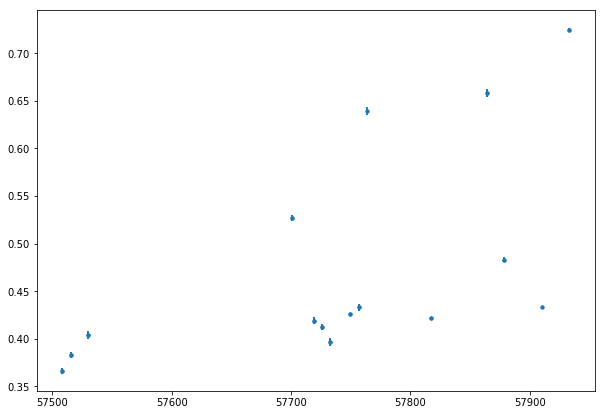

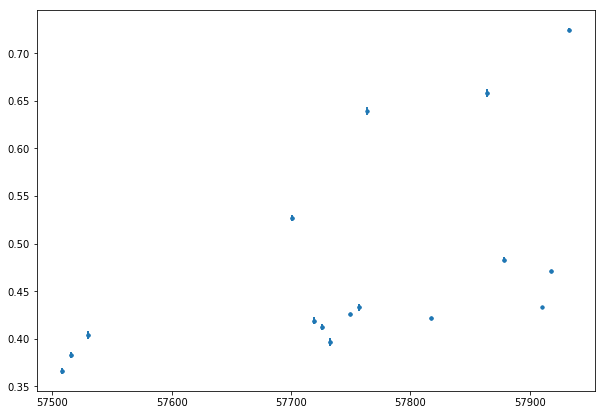

In [32]:
plt.figure(figsize=(10,7))
plt.errorbar(comp_array_mod_2[:,0],comp_array_mod_2[:,3],yerr=comp_array_mod_2[:,4],fmt='.')
#plt.ylim([0.02,0.07])
plt.show()

plt.figure(figsize=(10,7))
plt.errorbar(comp_array_2[:,0],comp_array_2[:,3],yerr=comp_array_2[:,4],fmt='.')
#plt.ylim([0.02,0.07])
plt.show()


In [52]:
comp_array,SNR_array,ABS_FLUX_LAMBDA_1_1,ABS_FLUX_LAMBDA_2_1,ABS_FLUX_LAMBDA_3_1,\
ABS_FLUX_V_1_1,ABS_FLUX_V_2_1,ABS_FLUX_V_3_1,date_1 = SEXAGNflux(quasJ,0.001)

Frame nr.  0 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017170BLs044.fits
1198.09683333
Frame nr.  1 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016330BLs067.fits
906.895166667
Frame nr.  2 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016141BLs054.fits
1001.488
Frame nr.  3 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017140BLs026.fits
1218.8315
Frame nr.  4 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017123BLs088.fits
1323.9125
Frame nr.  5 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017039BLs095.fits
798.9385
Frame nr.  6 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016352BLs055.fits
910.237333333
Frame nr.  7 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016195BLs019.fits
854.885333333
Frame nr.  8 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016344BLs089.fits
877.879833333
Frame nr.  9 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017017BLs105.fits
781.8005
Frame nr.  10 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017009BLs117.fits
909.049666667
Frame nr.  11 /../home/lynge/MasterP/NGC378

1031.13166667
Frame nr.  95 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016141BLs053.fits
993.012
Frame nr.  96 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016337BLs098.fits
937.3285
Frame nr.  97 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016322BLs116.fits
nan
Frame nr.  98 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017187BLs029.fits
733.045
Frame nr.  99 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016134BLs064.fits
nan
Frame nr.  100 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017024BLs109.fits
714.273166667
Frame nr.  101 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017031BLs111.fits
779.027166667
Frame nr.  102 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016141BLs052.fits
991.097166667
Frame nr.  103 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016210BLs021.fits
910.1415
Frame nr.  104 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017062BLs065.fits
796.763333333
Frame nr.  105 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016210BLs022.fits
901.067333333
Frame nr.  106 /../home/lynge/Ma

In [53]:
print np.nanmean(comp_array[:,4]), np.nanstd(comp_array[:,4])
comp_array_mod = np.copy(comp_array)
comp_array_mod[comp_array[:,4] < np.nanmean(comp_array[:,4]) - 0.5*np.nanstd(comp_array[:,4]),1:5] = float('nan')


905.632886139 164.75452396


In [54]:
print np.nanmean(comp_array[:,4])
print np.nanmean(comp_array_mod[:,4])

905.632886139
988.975012438


In [55]:
#print comp_array_mod
comp_array_mod_2 = np.zeros((len(comp_array_mod[:,0]),13))
#comp_array_mod_2[0,0] = comp_array_mod[0,0]
tjek = 0
acceptance = 0.01

for i in range(len(comp_array_mod)):
    if comp_array_mod[i,0] != comp_array_mod_2[tjek,0]:
        comp_array_mod_2[tjek,0] = comp_array_mod[i,0]
        com1 = []
        com2 = []
        com3 = []
        for j in range(len(comp_array_mod)):
            if comp_array_mod_2[tjek,0] == comp_array_mod[j,0]:
                com1.append(comp_array_mod[j,1])
                com2.append(comp_array_mod[j,2])
                com3.append(comp_array_mod[j,3])
        comp_array_mod_2[tjek,1] = np.mean(com1)
        comp_array_mod_2[tjek,2] = np.std(com1)
        if comp_array_mod_2[tjek,2]/float(comp_array_mod_2[tjek,1]) > acceptance or float(comp_array_mod_2[tjek,1]) < 0:
            comp_array_mod_2[tjek,1] = float('nan')
            comp_array_mod_2[tjek,2] = float('nan')
        comp_array_mod_2[tjek,3] = np.mean(com2)
        comp_array_mod_2[tjek,4] = np.std(com2)
        if comp_array_mod_2[tjek,4]/float(comp_array_mod_2[tjek,3]) > acceptance or float(comp_array_mod_2[tjek,3]) < 0:
            comp_array_mod_2[tjek,3] = float('nan')
            comp_array_mod_2[tjek,4] = float('nan')
        comp_array_mod_2[tjek,5] = np.mean(com3)
        comp_array_mod_2[tjek,6] = np.std(com3)
        if comp_array_mod_2[tjek,6]/float(comp_array_mod_2[tjek,5]) > acceptance or float(comp_array_mod_2[tjek,5]) < 0:
            comp_array_mod_2[tjek,5] = float('nan')
            comp_array_mod_2[tjek,6] = float('nan')
        tjek = tjek + 1


np.savetxt('NGC3783-z',comp_array_mod)


In [37]:
#print comp_array
comp_array_2 = np.zeros((len(comp_array[:,0]),13))
#comp_array_2[0,0] = comp_array[0,0]
tjek = 0
acceptance = 0.01

for i in range(len(comp_array)):
    if comp_array[i,0] != comp_array_2[tjek,0]:
        comp_array_2[tjek,0] = comp_array[i,0]
        com1 = []
        com2 = []
        com3 = []
        for j in range(len(comp_array)):
            if comp_array_2[tjek,0] == comp_array[j,0]:
                com1.append(comp_array[j,1])
                com2.append(comp_array[j,2])
                com3.append(comp_array[j,3])
        comp_array_2[tjek,1] = np.mean(com1)
        comp_array_2[tjek,2] = np.std(com1)
        if comp_array_2[tjek,2]/float(comp_array_2[tjek,1]) > acceptance or float(comp_array_2[tjek,1]) < 0:
            comp_array_2[tjek,1] = float('nan')
            comp_array_2[tjek,2] = float('nan')
        comp_array_2[tjek,3] = np.mean(com2)
        comp_array_2[tjek,4] = np.std(com2)
        if comp_array_2[tjek,4]/float(comp_array_2[tjek,3]) > acceptance or float(comp_array_2[tjek,3]) < 0:
            comp_array_2[tjek,3] = float('nan')
            comp_array_2[tjek,4] = float('nan')
        comp_array_2[tjek,5] = np.mean(com3)
        comp_array_2[tjek,6] = np.std(com3)
        if comp_array_2[tjek,6]/float(comp_array_2[tjek,5]) > acceptance or float(comp_array_2[tjek,5]) < 0:
            comp_array_2[tjek,5] = float('nan')
            comp_array_2[tjek,6] = float('nan')
        tjek = tjek + 1

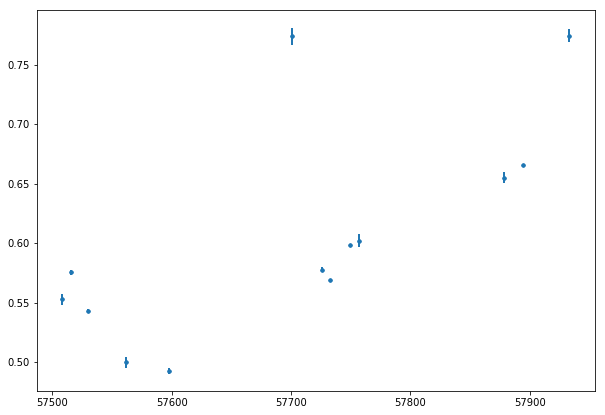

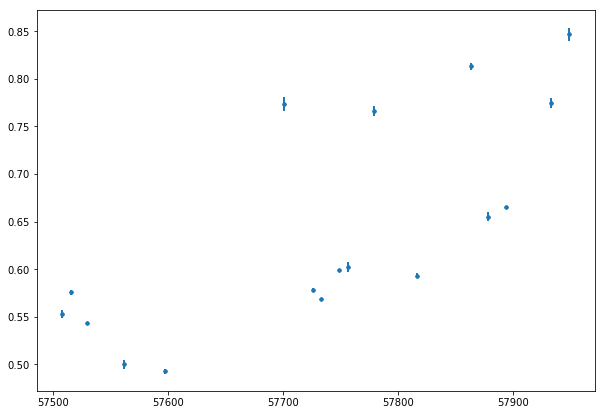

In [38]:
plt.figure(figsize=(10,7))
plt.errorbar(comp_array_mod_2[:,0],comp_array_mod_2[:,3],yerr=comp_array_mod_2[:,4],fmt='.')
#plt.ylim([0.02,0.07])
plt.show()

plt.figure(figsize=(10,7))
plt.errorbar(comp_array_2[:,0],comp_array_2[:,3],yerr=comp_array_2[:,4],fmt='.')
#plt.ylim([0.02,0.07])
plt.show()


In [39]:
comp_array,SNR_array,ABS_FLUX_LAMBDA_1_1,ABS_FLUX_LAMBDA_2_1,ABS_FLUX_LAMBDA_3_1,\
ABS_FLUX_V_1_1,ABS_FLUX_V_2_1,ABS_FLUX_V_3_1,date_1 = SEXAGNflux(quasJ,0.003)

Frame nr.  0 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017170BLs044.fits
2464.30166667
Frame nr.  1 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016330BLs067.fits
1988.13333333
Frame nr.  2 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016141BLs054.fits
2182.325
Frame nr.  3 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017140BLs026.fits
2455.335
Frame nr.  4 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017123BLs088.fits
2659.44166667
Frame nr.  5 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017039BLs095.fits
1733.60833333
Frame nr.  6 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016352BLs055.fits
1944.18666667
Frame nr.  7 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016195BLs019.fits
2175.25333333
Frame nr.  8 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016344BLs089.fits
1930.795
Frame nr.  9 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017017BLs105.fits
1687.99333333
Frame nr.  10 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017009BLs117.fits
1953.555
Frame nr.  11 /../home/lynge/MasterP/NGC

2315.38833333
Frame nr.  95 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016141BLs053.fits
2135.76833333
Frame nr.  96 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016337BLs098.fits
2082.35833333
Frame nr.  97 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016322BLs116.fits
nan
Frame nr.  98 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017187BLs029.fits
2186.4
Frame nr.  99 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016134BLs064.fits
nan
Frame nr.  100 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017024BLs109.fits
1597.27216667
Frame nr.  101 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017031BLs111.fits
1707.145
Frame nr.  102 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016141BLs052.fits
2140.50166667
Frame nr.  103 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016210BLs021.fits
2123.42833333
Frame nr.  104 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2017062BLs065.fits
1695.40666667
Frame nr.  105 /../home/lynge/MasterP/NGC3783/NGC3783z/IMG2016210BLs022.fits
2059.99666667
Frame nr.  106 /../hom

In [40]:
print np.nanmean(comp_array[:,4]), np.nanstd(comp_array[:,4])
comp_array_mod = np.copy(comp_array)
comp_array_mod[comp_array[:,4] < np.nanmean(comp_array[:,4]) - 0.5*np.nanstd(comp_array[:,4]),1:5] = float('nan')


1986.65625578 317.730513499


In [41]:
print np.nanmean(comp_array[:,4])
print np.nanmean(comp_array_mod[:,4])

1986.65625578
2165.23176617


In [42]:
#print comp_array_mod
comp_array_mod_2 = np.zeros((len(comp_array_mod[:,0]),13))
#comp_array_mod_2[0,0] = comp_array_mod[0,0]
tjek = 0
acceptance = 0.01

for i in range(len(comp_array_mod)):
    if comp_array_mod[i,0] != comp_array_mod_2[tjek,0]:
        comp_array_mod_2[tjek,0] = comp_array_mod[i,0]
        com1 = []
        com2 = []
        com3 = []
        for j in range(len(comp_array_mod)):
            if comp_array_mod_2[tjek,0] == comp_array_mod[j,0]:
                com1.append(comp_array_mod[j,1])
                com2.append(comp_array_mod[j,2])
                com3.append(comp_array_mod[j,3])
        comp_array_mod_2[tjek,1] = np.mean(com1)
        comp_array_mod_2[tjek,2] = np.std(com1)
        if comp_array_mod_2[tjek,2]/float(comp_array_mod_2[tjek,1]) > acceptance or float(comp_array_mod_2[tjek,1]) < 0:
            comp_array_mod_2[tjek,1] = float('nan')
            comp_array_mod_2[tjek,2] = float('nan')
        comp_array_mod_2[tjek,3] = np.mean(com2)
        comp_array_mod_2[tjek,4] = np.std(com2)
        if comp_array_mod_2[tjek,4]/float(comp_array_mod_2[tjek,3]) > acceptance or float(comp_array_mod_2[tjek,3]) < 0:
            comp_array_mod_2[tjek,3] = float('nan')
            comp_array_mod_2[tjek,4] = float('nan')
        comp_array_mod_2[tjek,5] = np.mean(com3)
        comp_array_mod_2[tjek,6] = np.std(com3)
        if comp_array_mod_2[tjek,6]/float(comp_array_mod_2[tjek,5]) > acceptance or float(comp_array_mod_2[tjek,5]) < 0:
            comp_array_mod_2[tjek,5] = float('nan')
            comp_array_mod_2[tjek,6] = float('nan')
        tjek = tjek + 1




In [43]:
#print comp_array
comp_array_2 = np.zeros((len(comp_array[:,0]),13))
#comp_array_2[0,0] = comp_array[0,0]
tjek = 0
acceptance = 0.01

for i in range(len(comp_array)):
    if comp_array[i,0] != comp_array_2[tjek,0]:
        comp_array_2[tjek,0] = comp_array[i,0]
        com1 = []
        com2 = []
        com3 = []
        for j in range(len(comp_array)):
            if comp_array_2[tjek,0] == comp_array[j,0]:
                com1.append(comp_array[j,1])
                com2.append(comp_array[j,2])
                com3.append(comp_array[j,3])
        comp_array_2[tjek,1] = np.mean(com1)
        comp_array_2[tjek,2] = np.std(com1)
        if comp_array_2[tjek,2]/float(comp_array_2[tjek,1]) > acceptance or float(comp_array_2[tjek,1]) < 0:
            comp_array_2[tjek,1] = float('nan')
            comp_array_2[tjek,2] = float('nan')
        comp_array_2[tjek,3] = np.mean(com2)
        comp_array_2[tjek,4] = np.std(com2)
        if comp_array_2[tjek,4]/float(comp_array_2[tjek,3]) > acceptance or float(comp_array_2[tjek,3]) < 0:
            comp_array_2[tjek,3] = float('nan')
            comp_array_2[tjek,4] = float('nan')
        comp_array_2[tjek,5] = np.mean(com3)
        comp_array_2[tjek,6] = np.std(com3)
        if comp_array_2[tjek,6]/float(comp_array_2[tjek,5]) > acceptance or float(comp_array_2[tjek,5]) < 0:
            comp_array_2[tjek,5] = float('nan')
            comp_array_2[tjek,6] = float('nan')
        tjek = tjek + 1

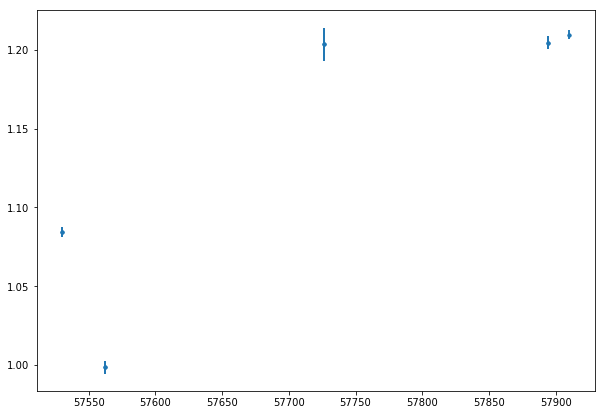

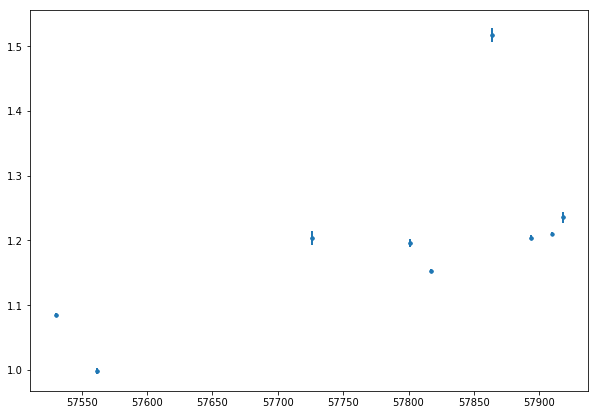

In [44]:
plt.figure(figsize=(10,7))
plt.errorbar(comp_array_mod_2[:,0],comp_array_mod_2[:,3],yerr=comp_array_mod_2[:,4],fmt='.')
#plt.ylim([0.02,0.07])
plt.show()

plt.figure(figsize=(10,7))
plt.errorbar(comp_array_2[:,0],comp_array_2[:,3],yerr=comp_array_2[:,4],fmt='.')
#plt.ylim([0.02,0.07])
plt.show()


In [45]:
def AGNflux(quas,aperture1):
    aperture2 = aperture1 + 0.001
    date = []
    flucompsta1 = []
    flucompsta2 = []
    flucompsta3 = []
    flucompsta4 = []
    flucompsta5 = []
    flucompsta6 = []
    flucompsta7 = []
    SNR1 = []
    SNR2 = []
    SNR3 = []
    SNR4 = []
    SNR5 = []
    poissonAGN = []
    poisson529 = []
    poisson22 = []
    poissonHD = []
    ABS_FLUX_LAMBDA_1 = 0
    ABS_FLUX_LAMBDA_2 = 0
    ABS_FLUX_LAMBDA_3 = 0
    ABS_FLUX_V_1 = 0
    ABS_FLUX_V_2 = 0
    ABS_FLUX_V_3 = 0
    SNR_comp = []
    for i in range(len(quas)):
        #print 'Frame nr. ', i
        header = pyfits.getheader(quas[i])
        a1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (qua1_RA_WORLD,qua1_DEC_WORLD),aperture1)[0]/header['EXPTIME'] #float(header['EXPTIME'])
        a2 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta1_RA_WORLD,sta1_DEC_WORLD),aperture1)[0]/header['EXPTIME'] #float(header['EXPTIME'])
        a3 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta2_RA_WORLD,sta2_DEC_WORLD),aperture1)[0]/header['EXPTIME'] #float(header['EXPTIME'])
        a4 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta3_RA_WORLD,sta3_DEC_WORLD),aperture1)[0]/header['EXPTIME'] #float(header['EXPTIME'])
        a_sky = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sky_RA_WORLD,sky_DEC_WORLD),aperture1)[0]/header['EXPTIME'] #float(header['EXPTIME'])
        a1_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (qua1_RA_WORLD,qua1_DEC_WORLD),aperture2)[0]/header['EXPTIME'] #float(header['EXPTIME'])
        a2_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta1_RA_WORLD,sta1_DEC_WORLD),aperture2)[0]/header['EXPTIME'] #float(header['EXPTIME'])
        a3_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta2_RA_WORLD,sta2_DEC_WORLD),aperture2)[0]/header['EXPTIME'] #float(header['EXPTIME'])
        a4_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta3_RA_WORLD,sta3_DEC_WORLD),aperture2)[0]/header['EXPTIME'] #float(header['EXPTIME'])
        date.append(header['MJD-OBS'])
        a_AGN_pix = np.pi*(2*aperture1)**2/np.count_nonzero(a1)
        a2_pix = np.pi*(2*aperture1)**2/np.count_nonzero(a2)
        a3_pix = np.pi*(2*aperture1)**2/np.count_nonzero(a3)
        a4_pix = np.pi*(2*aperture1)**2/np.count_nonzero(a4)
        a_AGN_pix_1 = np.pi*(2*aperture1)**2/np.count_nonzero(a1_1)
        a2_pix_1 = np.pi*(2*aperture1)**2/np.count_nonzero(a2_1)
        a3_pix_1 = np.pi*(2*aperture1)**2/np.count_nonzero(a3_1)
        a4_pix_1 = np.pi*(2*aperture1)**2/np.count_nonzero(a4_1)
        a_AGN_3 = np.sum(a1)/a_AGN_pix - (np.sum(a1_1) - np.sum(a1))/(a_AGN_pix_1 - a_AGN_pix)#Background subtracted flux/pixel/sec
        a2_3 = np.sum(a2)/a2_pix - (np.sum(a2_1) - np.sum(a2))/(a2_pix_1 - a2_pix)
        a3_3 = np.sum(a3)/a3_pix - (np.sum(a3_1) - np.sum(a3))/(a3_pix_1 - a3_pix)
        a4_3 = np.sum(a4)/a4_pix - (np.sum(a4_1) - np.sum(a4))/(a4_pix_1 - a4_pix)
        flucompsta1.append(comp1(a_AGN_3,a2_3))
        flucompsta2.append(comp1(a_AGN_3,a3_3))
        flucompsta3.append(comp1(a_AGN_3,a4_3))
        SNR1.append(SNR(np.sum(a1),np.sum(a_sky),header,aperture1,aperture1))
        SNR2.append(SNR(np.sum(a2),np.sum(a_sky),header,aperture1,aperture1))
        SNR3.append(SNR(np.sum(a3),np.sum(a_sky),header,aperture1,aperture1))
        SNR4.append(SNR(np.sum(a4),np.sum(a_sky),header,aperture1,aperture1))
        poissonAGN.append(np.sqrt(np.sum(a1)*header['EXPTIME']))
        poissonHD.append(np.sqrt(np.sum(a2)*header['EXPTIME']))
        poisson22.append(np.sqrt(np.sum(a3)*header['EXPTIME']))
        poisson529.append(np.sqrt(np.sum(a4)*header['EXPTIME']))
        #print header['EXPTIME']
    poissonAGN = np.array(poissonAGN)
    poissonHD = np.array(poissonHD)
    poisson22 = np.array(poisson22)
    poisson529 = np.array(poisson529)
    ABS_FLUX_LAMBDA_1 = np.array(flucompsta1)*flux_cal(MAG_HD101274_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_2 = np.array(flucompsta2)*flux_cal(MAG_TYCHO_2_7740_22_1_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_3 = np.array(flucompsta3)*flux_cal(MAG_TYCHO_2_7740_529_1_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_V_1 = np.array(flucompsta1)*flux_cal(MAG_HD101274_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_2 = np.array(flucompsta2)*flux_cal(MAG_TYCHO_2_7740_22_1_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_3 = np.array(flucompsta3)*flux_cal(MAG_TYCHO_2_7740_529_1_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    return np.array(flucompsta1),np.array(flucompsta2),np.array(flucompsta3),np.array(flucompsta4),\
np.array(flucompsta5),np.array(flucompsta6),np.array(flucompsta7),np.array(SNR1),np.array(SNR2),np.array(SNR3),\
np.array(SNR4),np.array(SNR5),np.array(SNR_comp),ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,\
ABS_FLUX_V_1,ABS_FLUX_V_2,ABS_FLUX_V_3,date,poissonAGN,poissonHD,poisson22,poisson529

In [47]:
flucompsta1,flucompsta2,flucompsta3,flucompsta4,flucompsta5,flucompsta6,flucompsta7,\
SNR1,SNR2,SNR3,SNR4,SNR5,SNR_comp,ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,ABS_FLUX_V_1,\
ABS_FLUX_V_2,ABS_FLUX_V_3,date,poissonAGN,poissonHD,poisson22,poisson529 = AGNflux(quasJ,0.001)

/home/lynge/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()
/home/lynge/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in sqrt


In [48]:
print np.shape(ABS_FLUX_V_3_1), np.shape(date_1)


(0,) (114,)


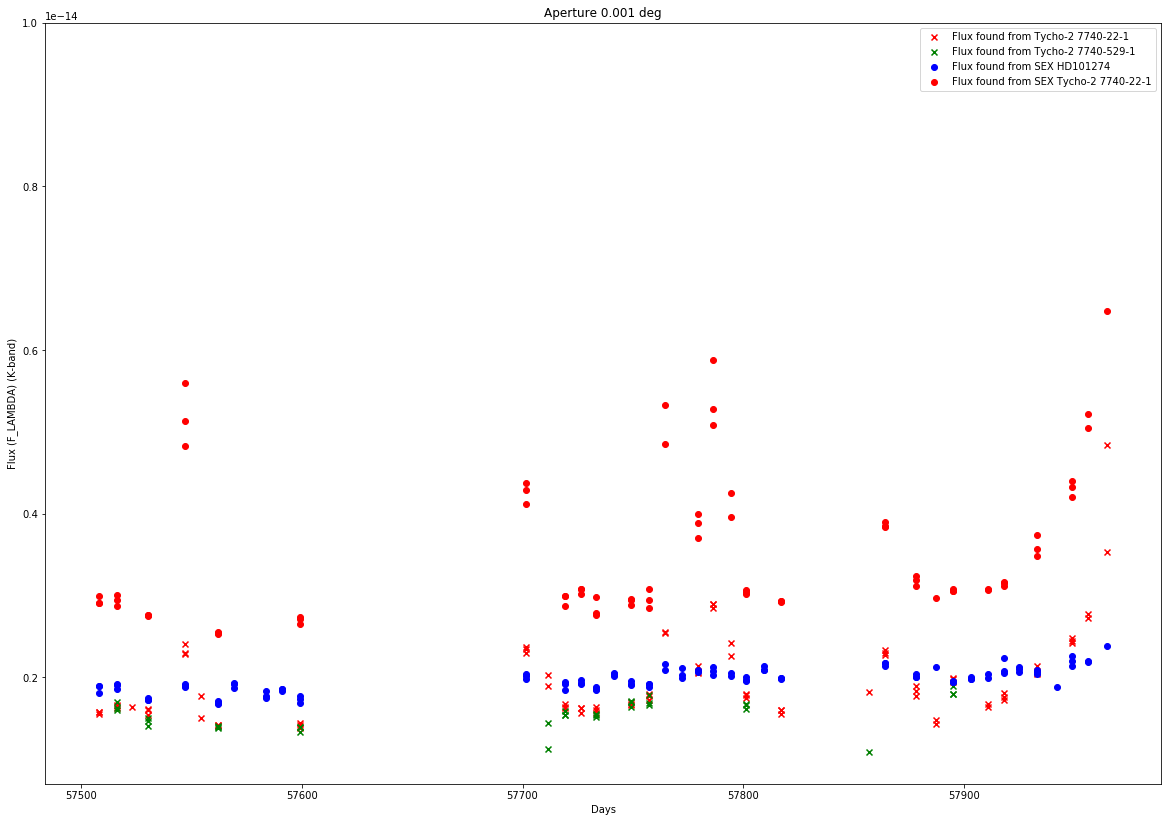

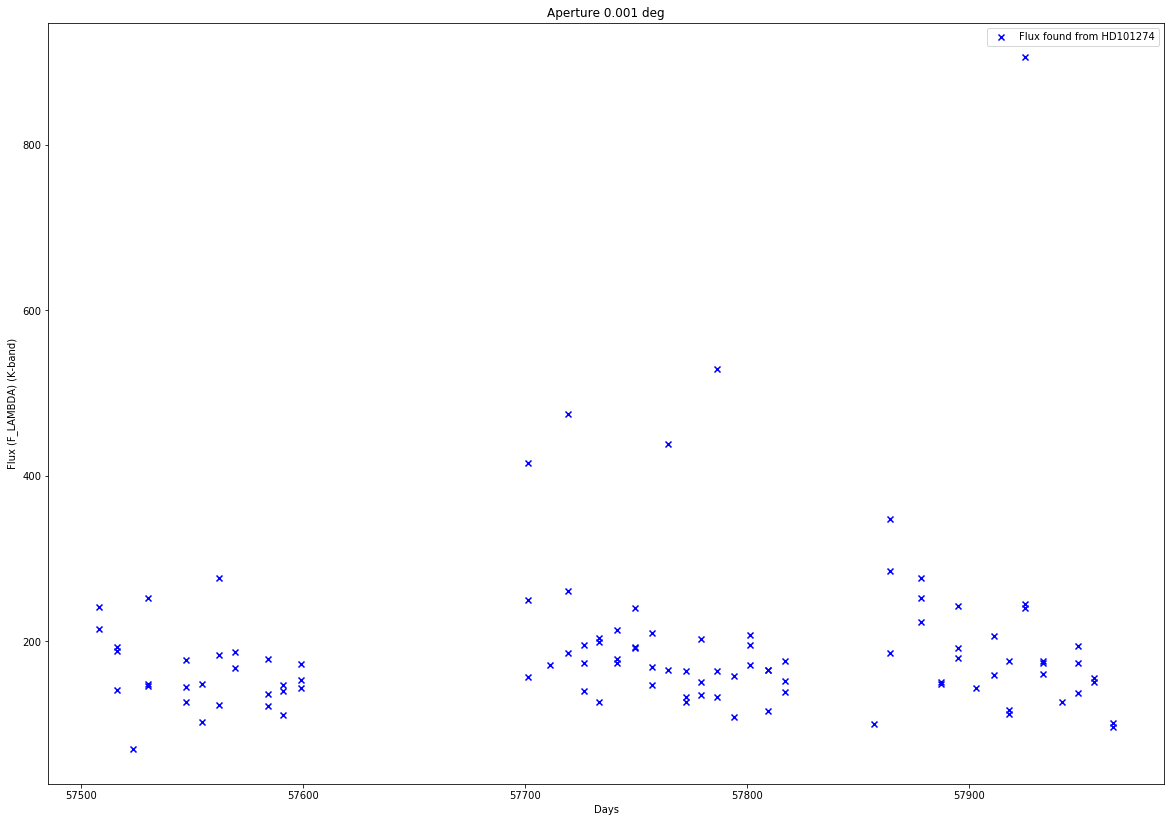

[             nan   1.67414907e-15   1.54579757e-15   1.94907909e-15
   1.83592047e-15   2.25695813e-15              nan              nan
   1.56858952e-15              nan   2.55851856e-15   2.42388655e-15
   2.29689180e-15              nan   2.84602656e-15   1.76924801e-15
   1.43343926e-15   1.79617877e-15   2.33058213e-15   1.76896890e-15
  -5.58485517e-16   2.13757016e-15   2.05898757e-15   1.41786559e-15
              nan   2.29357268e-15   2.54763806e-15              nan
   2.05546724e-15   1.59605619e-15              nan   1.41598838e-15
   1.62140345e-15   2.06250481e-15   3.52889888e-15   1.55344652e-15
   2.48261739e-15   2.37202593e-15   1.66922931e-15              nan
              nan   2.35184951e-15   2.03196552e-15   1.42263953e-15
   1.57671300e-15   2.44564346e-15   1.55942370e-15   1.72502208e-15
   1.62284931e-15   2.90303986e-15   1.55505810e-15   2.04139047e-15
   1.89108010e-15              nan   1.97903145e-15   1.74514395e-15
              nan   2.72077625e-15

In [49]:
plt.figure(figsize=(20,14))
#plt.scatter(date,np.array(ABS_FLUX_LAMBDA_1),marker='x',\
#            color='b',label='Flux found from HD101274')
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_2),marker='x',\
            color='r',label='Flux found from Tycho-2 7740-22-1')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3),marker='x',\
            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.scatter(date_1,ABS_FLUX_LAMBDA_1_1,marker='o',\
            color='b',label='Flux found from SEX HD101274')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_2_1),marker='o',\
            color='r',label='Flux found from SEX Tycho-2 7740-22-1')
#plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3_1),marker='o',\
#            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
plt.ylim([0.07*10**(-14),1*10**(-14)])
#plt.xlim([57580,57600])
plt.legend()
plt.show()

plt.figure(figsize=(20,14))
plt.scatter(date,np.array(SNR1),marker='x',\
            color='b',label='Flux found from HD101274')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
#plt.ylim([0.15,0.20])
#plt.xlim([57580,57600])
plt.legend()
plt.show()

num = np.nanargmax(ABS_FLUX_LAMBDA_2_1)

print ABS_FLUX_LAMBDA_2
print ABS_FLUX_LAMBDA_2[num]
print num
print date[num]
print quasJ[num]


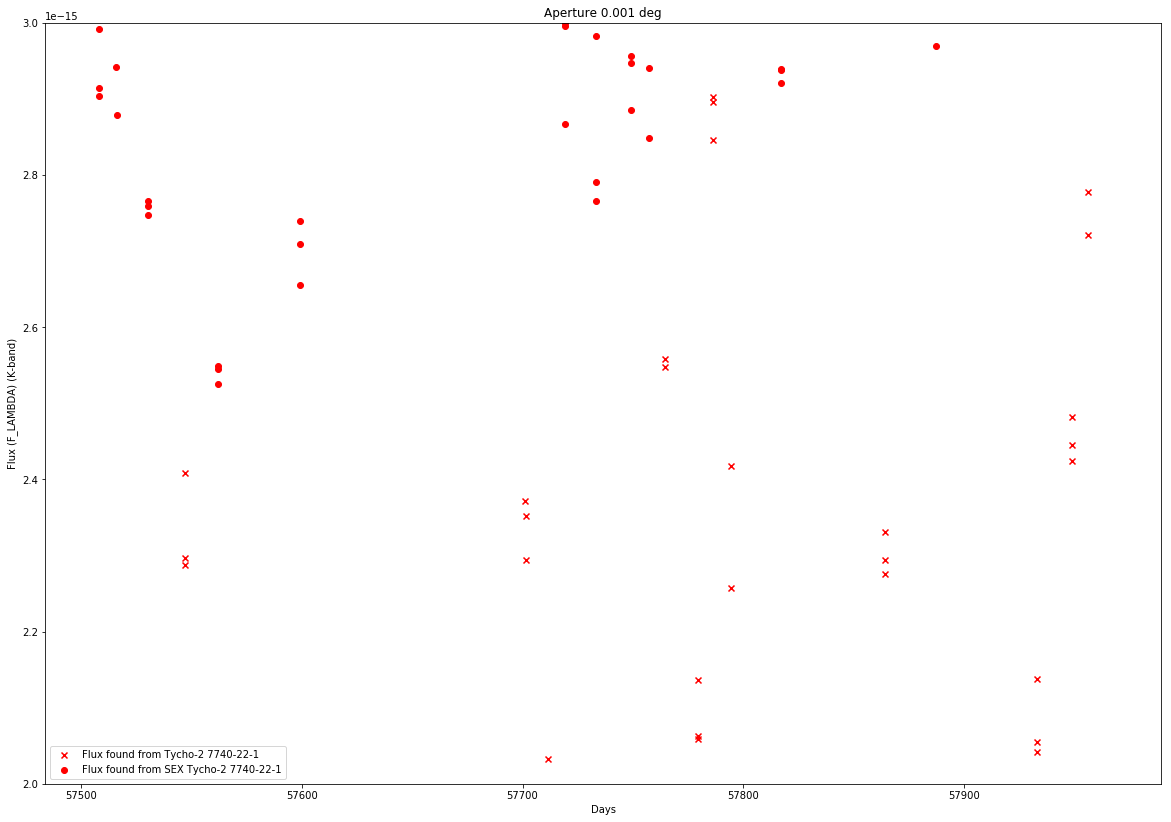

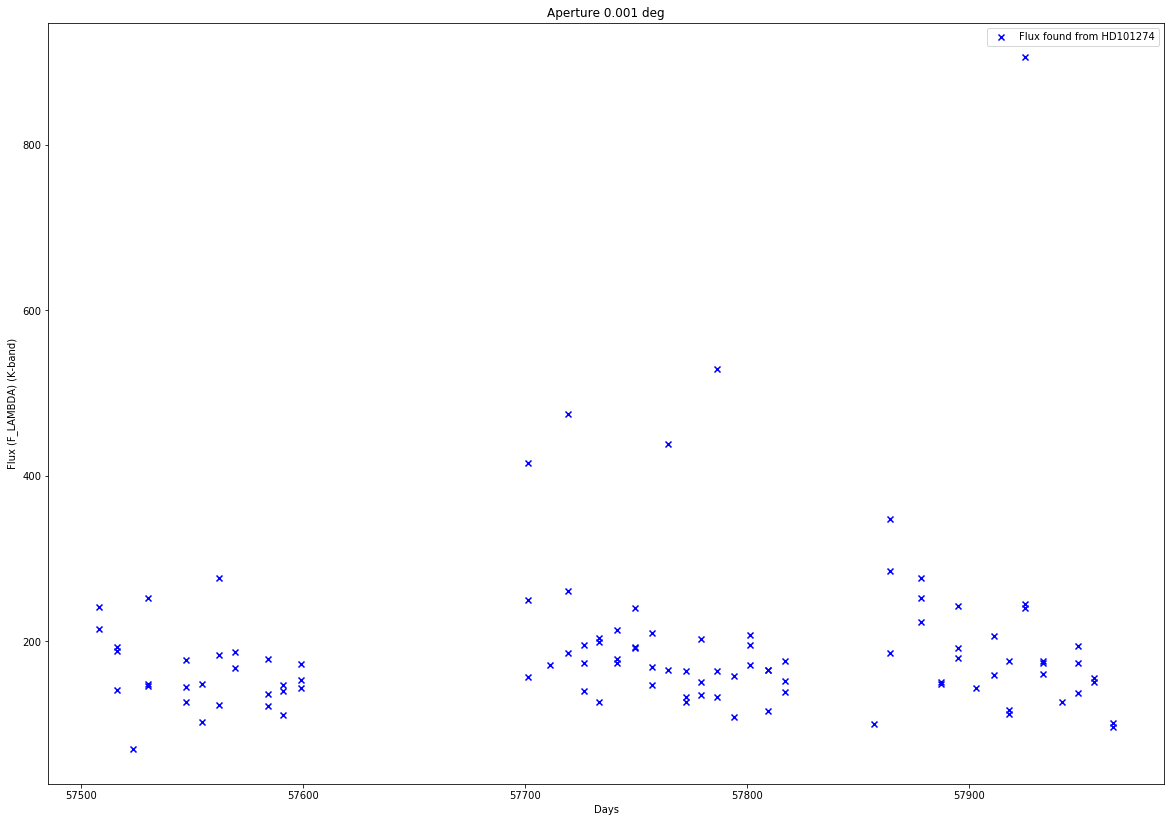

[             nan   1.67414907e-15   1.54579757e-15   1.94907909e-15
   1.83592047e-15   2.25695813e-15              nan              nan
   1.56858952e-15              nan   2.55851856e-15   2.42388655e-15
   2.29689180e-15              nan   2.84602656e-15   1.76924801e-15
   1.43343926e-15   1.79617877e-15   2.33058213e-15   1.76896890e-15
  -5.58485517e-16   2.13757016e-15   2.05898757e-15   1.41786559e-15
              nan   2.29357268e-15   2.54763806e-15              nan
   2.05546724e-15   1.59605619e-15              nan   1.41598838e-15
   1.62140345e-15   2.06250481e-15   3.52889888e-15   1.55344652e-15
   2.48261739e-15   2.37202593e-15   1.66922931e-15              nan
              nan   2.35184951e-15   2.03196552e-15   1.42263953e-15
   1.57671300e-15   2.44564346e-15   1.55942370e-15   1.72502208e-15
   1.62284931e-15   2.90303986e-15   1.55505810e-15   2.04139047e-15
   1.89108010e-15              nan   1.97903145e-15   1.74514395e-15
              nan   2.72077625e-15

In [50]:
plt.figure(figsize=(20,14))
#plt.scatter(date,np.array(ABS_FLUX_LAMBDA_1),marker='x',\
#            color='b',label='Flux found from HD101274')
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_2),marker='x',\
            color='r',label='Flux found from Tycho-2 7740-22-1')
#plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3),marker='x',\
#            color='g',label='Flux found from Tycho-2 7740-529-1')
#plt.scatter(date_1,ABS_FLUX_LAMBDA_1_1,marker='o',\
#            color='b',label='Flux found from SEX HD101274')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_2_1),marker='o',\
            color='r',label='Flux found from SEX Tycho-2 7740-22-1')
#plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3_1),marker='o',\
#            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
plt.ylim([0.2*10**(-14),0.3*10**(-14)])
#plt.xlim([57580,57600])
plt.legend()
plt.show()

plt.figure(figsize=(20,14))
plt.scatter(date,np.array(SNR1),marker='x',\
            color='b',label='Flux found from HD101274')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
#plt.ylim([0.15,0.20])
#plt.xlim([57580,57600])
plt.legend()
plt.show()

num = np.nanargmax(ABS_FLUX_LAMBDA_2_1)

print ABS_FLUX_LAMBDA_2
print ABS_FLUX_LAMBDA_2[num]
print num
print date[num]
print quasJ[num]


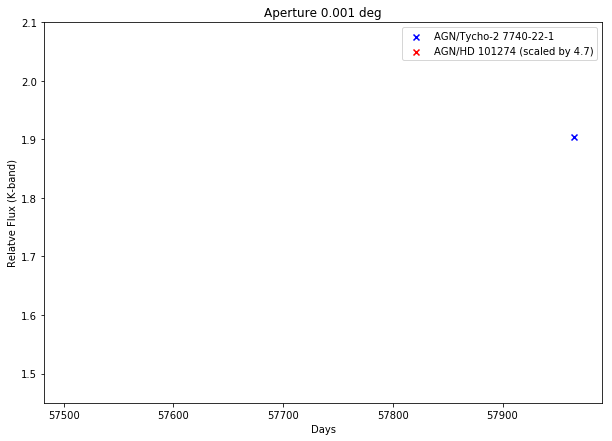

In [51]:

plt.figure(figsize=(10,7))
plt.scatter(date,flucompsta2,marker='x',\
            color='b',label='AGN/Tycho-2 7740-22-1')
plt.scatter(date,flucompsta1*6.2,marker='x',\
            color='r',label='AGN/HD 101274 (scaled by 4.7)')
#plt.scatter(date,flucompsta4*2.2,marker='x',\
#            color='g',label='AGN/Tycho-2 7740-529-1 (scaled by 2.2)')
plt.xlabel('Days')
plt.ylabel('Relatve Flux (K-band)')
plt.title('Aperture 0.001 deg')
plt.ylim([1.45,2.1])
plt.legend()
plt.show()


